In [10]:
import csv
from datetime import datetime
import json
import math
import os
import sys
import time
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

## Define Model

In [55]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, input_dim=60, hidden_dims=[32, 16], latent_dim=8, standalize=True):
        super(AutoEncoder, self).__init__()
        
        encoder_layers = []
        in_features = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.append(nn.Linear(in_features, hidden_dim))
            encoder_layers.append(nn.ReLU())
            in_features = hidden_dim
        encoder_layers.append(nn.Linear(in_features, latent_dim))
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        decoder_layers = []
        in_features = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(in_features, hidden_dim))
            decoder_layers.append(nn.ReLU())
            in_features = hidden_dim
        decoder_layers.append(nn.Linear(in_features, input_dim))
        if standalize:
            decoder_layers.append(nn.Sigmoid())
        
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        y = self.decoder(x)
        return y, x

batch_size = 30
observation_length = 60
feature_size = 1
input_tensor = torch.randn((batch_size, observation_length, feature_size))

input_dim = input_tensor.shape[1]
model = AutoEncoder(input_dim=input_dim, hidden_dims=[48, 24], latent_dim=12)

output, middle = model(input_tensor)
print("Output shape:", output.shape, "Middle Layer Output:", middle.shape)

Output shape: torch.Size([30, 60]) Middle Layer Output: torch.Size([30, 12])


In [63]:
def train(model, ds, optimizer, criterion, batch_size):
    
    model.train()
    ds.train()
    losses = 0
    
    end_index = len(ds) - batch_size
    for index in tqdm(range(0, end_index, batch_size)):
        src, tgt = ds[index:index+batch_size]

        output, memory = model(src)
        optimizer.zero_grad()
        loss = criterion(output, src.view(src.size(0), -1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / end_index

In [65]:
def evaluate(model, ds, criterion, batch_size):
    
    model.eval()
    ds.eval()
    losses = 0
    
    end_index = len(ds) - batch_size
    for index in tqdm(range(0, end_index, batch_size)):
        src, tgt = ds[index:index+batch_size]

        output, memory = model(src)
        loss = criterion(output, src.view(src.size(0), -1))
        losses += loss.item()
        
    return losses / end_index

## Close Differential Array Token

### Define Dataset

In [11]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.base import Dataset
from fprocess import fprocess

In [45]:
class DiffDataset(Dataset):    
    key = "close"

    def __init__(self, df, columns=["close"], observation_length:int=30, 
                 device="cuda", prediction_length=10, seed=1017, is_training = True, randomize=True):
        
        processes = [fprocess.DiffPreProcess(periods=1)]
        super().__init__(df, columns, observation_length, device, processes, prediction_length, seed, is_training, randomize, batch_first=True)
        self._columns = columns.copy()
                
    def _output_func(self, batch_size: slice):
        batch_indices = batch_size
        chunk_tgt = []
        ndx = self._indices[batch_indices]
        
        for index in ndx:
            start_index = index + self.observation_length
            stop_index = index + self.observation_length + self._prediction_length
            step_ndx = slice(start_index, stop_index)
            future_tgt = self._data[self._columns].iloc[step_ndx].values.tolist()
            chunk_tgt.append(future_tgt)
        
        return torch.tensor(chunk_tgt, device=self.device, dtype=torch.float)
    
    def _input_func(self, batch_size: slice):
        batch_indices = batch_size
        chunk_src = []
        ndx = self._indices[batch_indices]
        
        for index in ndx:
            stop_index = index + self.observation_length
            obs_ndx = slice(index, stop_index)
            obs_src = self._data[self._columns].iloc[obs_ndx].values.tolist()
            chunk_src.append(obs_src)
    
        return torch.tensor(chunk_src, device=self.device, dtype=torch.float)

    def _init_indicies(self, data, randomize, split_ratio=0.7):
        length = len(data) - self.observation_length - self._prediction_length
        if length < 0:
            raise Exception(f"date length {length} is less than observation_length {self.observation_length}")
        
        from_index = 1
        to_index = int(length*split_ratio)
        self.train_indices = random.sample(range(from_index, to_index), k=to_index - from_index)
        
        from_index = int(length*split_ratio) + self.observation_length + self._prediction_length
        to_index = length
        self.val_indices = random.sample(range(from_index, to_index), k=to_index - from_index)
        
        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.val_indices
            
    def eval(self):
        self._indices = self.val_indices
        self.is_training = False
        
    def train(self):
        self._indices = self.train_indices
        self.is_training = True

### Training

In [16]:
ohlc_column = ['open','high','low','close']
file_path = os.path.abspath('../../../Data/fx/mt5_USDJPY_min30.zip')

df = pd.read_csv(file_path, index_col=0, parse_dates=True)
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
observation_length = 60
prediction_length = 10
columns = ["close"]
feature_size = len(columns)

ds = DiffDataset(df, columns=columns, observation_length=observation_length)

In [43]:
model_name = "finance_close_autoencoder"
model_version = 1

In [72]:
model = AutoEncoder(input_dim=observation_length*feature_size, 
                    hidden_dims=[observation_length], latent_dim=int(observation_length/2),
                    standalize=False)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [73]:
lr = 1e-3

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [76]:
epoch = 5000
# best_loss = float('Inf')
# best_model = None
patience = 3
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter >= patience:
        break

100%|██████████| 668/668 [00:38<00:00, 17.36it/s]


[1/5000] train loss: 0.0001026415, valid loss: 0.0000970694  50s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 19.07it/s]


[2/5000] train loss: 0.0001026413, valid loss: 0.0000970692  46s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.97it/s]


[3/5000] train loss: 0.0001026411, valid loss: 0.0000970692  35s] count: 0, 


100%|██████████| 668/668 [00:36<00:00, 18.38it/s]


[4/5000] train loss: 0.0001026400, valid loss: 0.0000970683  32s] count: 1, **


100%|██████████| 668/668 [00:35<00:00, 18.80it/s]


[5/5000] train loss: 0.0001026397, valid loss: 0.0000970685  36s] count: 0, 


100%|██████████| 668/668 [00:34<00:00, 19.45it/s]


[6/5000] train loss: 0.0001026387, valid loss: 0.0000970682  28s] count: 1, **


100%|██████████| 668/668 [00:34<00:00, 19.33it/s]


[7/5000] train loss: 0.0001026384, valid loss: 0.0000970676  20s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.99it/s]


[8/5000] train loss: 0.0001026384, valid loss: 0.0000970677  28s] count: 0, 


100%|██████████| 668/668 [00:31<00:00, 21.22it/s]


[9/5000] train loss: 0.0001026373, valid loss: 0.0000970669  15s] count: 1, **


100%|██████████| 668/668 [00:32<00:00, 20.87it/s]


[10/5000] train loss: 0.0001026372, valid loss: 0.0000970671  19s] count: 0, 


100%|██████████| 668/668 [00:36<00:00, 18.34it/s]


[11/5000] train loss: 0.0001026361, valid loss: 0.0000970669  50s] count: 1, 


100%|██████████| 668/668 [00:38<00:00, 17.30it/s]


[12/5000] train loss: 0.0001026353, valid loss: 0.0000970662  39s] count: 2, **


100%|██████████| 668/668 [00:36<00:00, 18.13it/s]


[13/5000] train loss: 0.0001026350, valid loss: 0.0000970664  32s] count: 0, 


100%|██████████| 668/668 [00:35<00:00, 19.06it/s]


[14/5000] train loss: 0.0001026342, valid loss: 0.0000970657  29s] count: 1, **


100%|██████████| 668/668 [00:38<00:00, 17.43it/s]


[15/5000] train loss: 0.0001026339, valid loss: 0.0000970659  30s] count: 0, 


100%|██████████| 668/668 [00:35<00:00, 18.97it/s]


[16/5000] train loss: 0.0001026332, valid loss: 0.0000970655  46s] count: 1, **


100%|██████████| 668/668 [00:35<00:00, 18.90it/s]


[17/5000] train loss: 0.0001026330, valid loss: 0.0000970653  29s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.86it/s]


[18/5000] train loss: 0.0001026329, valid loss: 0.0000970651  29s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.75it/s]


[19/5000] train loss: 0.0001026327, valid loss: 0.0000970649  28s] count: 0, **


100%|██████████| 668/668 [00:36<00:00, 18.53it/s]


[20/5000] train loss: 0.0001026326, valid loss: 0.0000970650  36s] count: 0, 


100%|██████████| 668/668 [00:35<00:00, 18.79it/s]


[21/5000] train loss: 0.0001026318, valid loss: 0.0000970646  29s] count: 1, **


100%|██████████| 668/668 [00:35<00:00, 18.95it/s]


[22/5000] train loss: 0.0001026316, valid loss: 0.0000970645  29s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.84it/s]


[23/5000] train loss: 0.0001026315, valid loss: 0.0000970644  30s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.82it/s]


[24/5000] train loss: 0.0001026314, valid loss: 0.0000970644  28s] count: 0, 


100%|██████████| 668/668 [00:35<00:00, 18.80it/s]


[25/5000] train loss: 0.0001026306, valid loss: 0.0000970642  30s] count: 1, **


100%|██████████| 668/668 [00:36<00:00, 18.46it/s]


[26/5000] train loss: 0.0001026305, valid loss: 0.0000970640  12s] count: 0, **


100%|██████████| 668/668 [00:36<00:00, 18.51it/s]


[27/5000] train loss: 0.0001026303, valid loss: 0.0000970639  34s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.82it/s]


[28/5000] train loss: 0.0001026302, valid loss: 0.0000970635  30s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.89it/s]


[29/5000] train loss: 0.0001026302, valid loss: 0.0000970636  29s] count: 0, 


100%|██████████| 668/668 [00:35<00:00, 18.85it/s]


[30/5000] train loss: 0.0001026295, valid loss: 0.0000970636  32s] count: 1, 


100%|██████████| 668/668 [00:35<00:00, 18.96it/s]


[31/5000] train loss: 0.0001026287, valid loss: 0.0000970631  29s] count: 2, **


100%|██████████| 668/668 [00:35<00:00, 19.00it/s]


[32/5000] train loss: 0.0001026285, valid loss: 0.0000970630  30s] count: 0, **


100%|██████████| 668/668 [00:37<00:00, 17.91it/s]


[33/5000] train loss: 0.0001026285, valid loss: 0.0000970630  31s] count: 0, **


100%|██████████| 668/668 [00:36<00:00, 18.43it/s]


[34/5000] train loss: 0.0001026283, valid loss: 0.0000970629  37s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.71it/s]


[35/5000] train loss: 0.0001026283, valid loss: 0.0000970628  31s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.59it/s]


[36/5000] train loss: 0.0001026281, valid loss: 0.0000970628  31s] count: 0, 


100%|██████████| 668/668 [00:35<00:00, 18.63it/s]


[37/5000] train loss: 0.0001026275, valid loss: 0.0000970625  30s] count: 1, **


100%|██████████| 668/668 [00:35<00:00, 18.78it/s]


[38/5000] train loss: 0.0001026273, valid loss: 0.0000970625  31s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.80it/s]


[39/5000] train loss: 0.0001026272, valid loss: 0.0000970625  31s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.93it/s]


[40/5000] train loss: 0.0001026272, valid loss: 0.0000970624  30s] count: 0, **


100%|██████████| 668/668 [00:37<00:00, 17.93it/s]


[41/5000] train loss: 0.0001026270, valid loss: 0.0000970623  30s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.82it/s]


[42/5000] train loss: 0.0001026269, valid loss: 0.0000970621  38s] count: 0, **


100%|██████████| 668/668 [00:40<00:00, 16.53it/s]


[43/5000] train loss: 0.0001026269, valid loss: 0.0000970623  30s] count: 0, 


100%|██████████| 668/668 [00:35<00:00, 18.76it/s]


[44/5000] train loss: 0.0001026262, valid loss: 0.0000970618  29s] count: 1, **


100%|██████████| 668/668 [00:35<00:00, 18.94it/s]


[45/5000] train loss: 0.0001026262, valid loss: 0.0000970617  30s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.98it/s]


[46/5000] train loss: 0.0001026261, valid loss: 0.0000970619  30s] count: 0, 


100%|██████████| 668/668 [00:35<00:00, 18.93it/s]


[47/5000] train loss: 0.0001026254, valid loss: 0.0000970616  30s] count: 1, **


100%|██████████| 668/668 [00:35<00:00, 18.65it/s]


[48/5000] train loss: 0.0001026254, valid loss: 0.0000970617  30s] count: 0, 


100%|██████████| 668/668 [00:30<00:00, 22.08it/s]


[49/5000] train loss: 0.0001026247, valid loss: 0.0000970614  20s] count: 1, **


100%|██████████| 668/668 [00:32<00:00, 20.64it/s]


[50/5000] train loss: 0.0001026247, valid loss: 0.0000970614  9s] count: 0, 


100%|██████████| 668/668 [00:30<00:00, 21.70it/s]


[51/5000] train loss: 0.0001026242, valid loss: 0.0000970612  15s] count: 1, **


100%|██████████| 668/668 [00:30<00:00, 22.25it/s]


[52/5000] train loss: 0.0001026240, valid loss: 0.0000970611  7s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.03it/s]


[53/5000] train loss: 0.0001026239, valid loss: 0.0000970611  47s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.06it/s]


[54/5000] train loss: 0.0001026238, valid loss: 0.0000970610  8s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.14it/s]


[55/5000] train loss: 0.0001026237, valid loss: 0.0000970609  6s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 21.78it/s]


[56/5000] train loss: 0.0001026237, valid loss: 0.0000970609  6s] count: 0, 


100%|██████████| 668/668 [00:29<00:00, 22.30it/s]


[57/5000] train loss: 0.0001026232, valid loss: 0.0000970607  8s] count: 1, **


100%|██████████| 668/668 [00:30<00:00, 21.99it/s]


[58/5000] train loss: 0.0001026231, valid loss: 0.0000970607  6s] count: 0, 


100%|██████████| 668/668 [00:30<00:00, 22.11it/s]


[59/5000] train loss: 0.0001026226, valid loss: 0.0000970606  6s] count: 1, **


100%|██████████| 668/668 [00:35<00:00, 18.83it/s]


[60/5000] train loss: 0.0001026225, valid loss: 0.0000970604  9s] count: 0, **


100%|██████████| 668/668 [00:33<00:00, 19.74it/s]


[61/5000] train loss: 0.0001026224, valid loss: 0.0000970606  27s] count: 0, 


100%|██████████| 668/668 [00:37<00:00, 17.95it/s]


[62/5000] train loss: 0.0001026220, valid loss: 0.0000970604  31s] count: 1, **


100%|██████████| 668/668 [00:37<00:00, 17.94it/s]


[63/5000] train loss: 0.0001026219, valid loss: 0.0000970604  32s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.10it/s]


[64/5000] train loss: 0.0001026218, valid loss: 0.0000970603  7s] count: 0, **


100%|██████████| 668/668 [00:31<00:00, 21.26it/s]


[65/5000] train loss: 0.0001026217, valid loss: 0.0000970602  7s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 21.90it/s]


[66/5000] train loss: 0.0001026216, valid loss: 0.0000970602  11s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.10it/s]


[67/5000] train loss: 0.0001026216, valid loss: 0.0000970601  6s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 21.78it/s]


[68/5000] train loss: 0.0001026215, valid loss: 0.0000970600  8s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.25it/s]


[69/5000] train loss: 0.0001026215, valid loss: 0.0000970600  6s] count: 0, 


100%|██████████| 668/668 [00:30<00:00, 22.02it/s]


[70/5000] train loss: 0.0001026210, valid loss: 0.0000970599  6s] count: 1, **


100%|██████████| 668/668 [00:30<00:00, 21.92it/s]


[71/5000] train loss: 0.0001026209, valid loss: 0.0000970599  9s] count: 0, 


100%|██████████| 668/668 [00:30<00:00, 22.08it/s]


[72/5000] train loss: 0.0001026205, valid loss: 0.0000970598  6s] count: 1, **


100%|██████████| 668/668 [00:30<00:00, 21.92it/s]


[73/5000] train loss: 0.0001026204, valid loss: 0.0000970598  6s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.20it/s]


[74/5000] train loss: 0.0001026204, valid loss: 0.0000970597  8s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 21.79it/s]


[75/5000] train loss: 0.0001026203, valid loss: 0.0000970597  6s] count: 0, 


100%|██████████| 668/668 [00:30<00:00, 21.91it/s]


[76/5000] train loss: 0.0001026199, valid loss: 0.0000970596  7s] count: 1, **


100%|██████████| 668/668 [00:30<00:00, 21.93it/s]


[77/5000] train loss: 0.0001026198, valid loss: 0.0000970596  9s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.01it/s]


[78/5000] train loss: 0.0001026198, valid loss: 0.0000970595  6s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.02it/s]


[79/5000] train loss: 0.0001026197, valid loss: 0.0000970594  6s] count: 0, **


100%|██████████| 668/668 [00:29<00:00, 22.28it/s]


[80/5000] train loss: 0.0001026196, valid loss: 0.0000970593  8s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 21.97it/s]


[81/5000] train loss: 0.0001026195, valid loss: 0.0000970593  6s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.24it/s]


[82/5000] train loss: 0.0001026195, valid loss: 0.0000970594  8s] count: 0, 


100%|██████████| 668/668 [00:30<00:00, 22.04it/s]


[83/5000] train loss: 0.0001026191, valid loss: 0.0000970593  10s] count: 1, **


100%|██████████| 668/668 [00:30<00:00, 22.07it/s]


[84/5000] train loss: 0.0001026191, valid loss: 0.0000970592  6s] count: 0, **


100%|██████████| 668/668 [00:30<00:00, 22.12it/s]


[85/5000] train loss: 0.0001026190, valid loss: 0.0000970592  6s] count: 0, **


100%|██████████| 668/668 [00:39<00:00, 16.84it/s]


[86/5000] train loss: 0.0001026189, valid loss: 0.0000970592  16s] count: 0, 


100%|██████████| 668/668 [00:37<00:00, 18.00it/s]


[87/5000] train loss: 0.0001026186, valid loss: 0.0000970591  7s] count: 1, **


100%|██████████| 668/668 [00:40<00:00, 16.52it/s]


[88/5000] train loss: 0.0001026185, valid loss: 0.0000970590  49s] count: 0, **


100%|██████████| 668/668 [00:38<00:00, 17.30it/s]


[89/5000] train loss: 0.0001026184, valid loss: 0.0000970590  47s] count: 0, 


100%|██████████| 668/668 [00:47<00:00, 14.03it/s]


[90/5000] train loss: 0.0001026181, valid loss: 0.0000970589  2s] count: 1, **


100%|██████████| 668/668 [00:44<00:00, 15.01it/s]


[91/5000] train loss: 0.0001026180, valid loss: 0.0000970589  7s] count: 0, 


100%|██████████| 668/668 [00:44<00:00, 14.91it/s]


[92/5000] train loss: 0.0001026177, valid loss: 0.0000970589  59s] count: 1, **


100%|██████████| 668/668 [00:44<00:00, 15.06it/s]


[93/5000] train loss: 0.0001026176, valid loss: 0.0000970588  4s] count: 0, **


100%|██████████| 668/668 [00:44<00:00, 15.05it/s]


[94/5000] train loss: 0.0001026176, valid loss: 0.0000970589  5s] count: 0, 


100%|██████████| 668/668 [00:43<00:00, 15.42it/s]


[95/5000] train loss: 0.0001026173, valid loss: 0.0000970588  5s] count: 1, **


100%|██████████| 668/668 [00:44<00:00, 15.12it/s]


[96/5000] train loss: 0.0001026172, valid loss: 0.0000970587  1s] count: 0, **


100%|██████████| 668/668 [00:43<00:00, 15.19it/s]


[97/5000] train loss: 0.0001026172, valid loss: 0.0000970588  8s] count: 0, 


100%|██████████| 668/668 [00:43<00:00, 15.31it/s]


[98/5000] train loss: 0.0001026169, valid loss: 0.0000970587  9s] count: 1, 


100%|██████████| 668/668 [00:44<00:00, 15.07it/s]


[99/5000] train loss: 0.0001026166, valid loss: 0.0000970585  25s] count: 2, **


100%|██████████| 668/668 [00:45<00:00, 14.81it/s]


[100/5000] train loss: 0.0001026165, valid loss: 0.0000970587  14s] count: 0, 


100%|██████████| 668/668 [00:43<00:00, 15.23it/s]


[101/5000] train loss: 0.0001026162, valid loss: 0.0000970586  12s] count: 1, 


100%|██████████| 668/668 [00:45<00:00, 14.60it/s]


[102/5000] train loss: 0.0001026160, valid loss: 0.0000970585  10s] count: 2, **


100%|██████████| 668/668 [00:46<00:00, 14.37it/s]


[103/5000] train loss: 0.0001026160, valid loss: 0.0000970584  8s] count: 0, **


100%|██████████| 668/668 [00:36<00:00, 18.14it/s]


[104/5000] train loss: 0.0001026159, valid loss: 0.0000970584  40s] count: 0, **


100%|██████████| 668/668 [00:34<00:00, 19.31it/s]


[105/5000] train loss: 0.0001026158, valid loss: 0.0000970585  37s] count: 0, 


100%|██████████| 668/668 [00:32<00:00, 20.42it/s]


[106/5000] train loss: 0.0001026156, valid loss: 0.0000970585  18s] count: 1, 


100%|██████████| 668/668 [00:32<00:00, 20.33it/s]


[107/5000] train loss: 0.0001026154, valid loss: 0.0000970584  19s] count: 2, **


100%|██████████| 668/668 [00:32<00:00, 20.82it/s]


[108/5000] train loss: 0.0001026153, valid loss: 0.0000970584  18s] count: 0, **


100%|██████████| 668/668 [00:32<00:00, 20.57it/s]


[109/5000] train loss: 0.0001026153, valid loss: 0.0000970583  17s] count: 0, **


100%|██████████| 668/668 [00:32<00:00, 20.71it/s]


[110/5000] train loss: 0.0001026153, valid loss: 0.0000970584  18s] count: 0, 


100%|██████████| 668/668 [00:32<00:00, 20.53it/s]


[111/5000] train loss: 0.0001026150, valid loss: 0.0000970583  17s] count: 1, **


100%|██████████| 668/668 [00:32<00:00, 20.58it/s]


[112/5000] train loss: 0.0001026150, valid loss: 0.0000970583  17s] count: 0, 


100%|██████████| 668/668 [00:32<00:00, 20.87it/s]


[113/5000] train loss: 0.0001026148, valid loss: 0.0000970582  16s] count: 1, **


100%|██████████| 668/668 [00:32<00:00, 20.69it/s]


[114/5000] train loss: 0.0001026147, valid loss: 0.0000970582  17s] count: 0, 


100%|██████████| 668/668 [00:32<00:00, 20.73it/s]


[115/5000] train loss: 0.0001026145, valid loss: 0.0000970582  18s] count: 1, **


100%|██████████| 668/668 [00:32<00:00, 20.69it/s]


[116/5000] train loss: 0.0001026145, valid loss: 0.0000970581  17s] count: 0, **


100%|██████████| 668/668 [00:32<00:00, 20.66it/s]


[117/5000] train loss: 0.0001026145, valid loss: 0.0000970581  17s] count: 0, 


100%|██████████| 668/668 [00:32<00:00, 20.79it/s]


[118/5000] train loss: 0.0001026142, valid loss: 0.0000970580  20s] count: 1, **


100%|██████████| 668/668 [00:32<00:00, 20.80it/s]


[119/5000] train loss: 0.0001026142, valid loss: 0.0000970580  18s] count: 0, 


100%|██████████| 668/668 [00:32<00:00, 20.46it/s]


[120/5000] train loss: 0.0001026141, valid loss: 0.0000970580  17s] count: 1, 


100%|██████████| 668/668 [00:31<00:00, 20.91it/s]


[121/5000] train loss: 0.0001026138, valid loss: 0.0000970580  18s] count: 2, **


100%|██████████| 668/668 [00:32<00:00, 20.60it/s]


[122/5000] train loss: 0.0001026138, valid loss: 0.0000970579  17s] count: 0, **


100%|██████████| 668/668 [00:35<00:00, 18.82it/s]


[123/5000] train loss: 0.0001026138, valid loss: 0.0000970579  17s] count: 0, **


100%|██████████| 668/668 [00:32<00:00, 20.68it/s]


[124/5000] train loss: 0.0001026138, valid loss: 0.0000970578  17s] count: 0, **


100%|██████████| 668/668 [00:32<00:00, 20.80it/s]


[125/5000] train loss: 0.0001026137, valid loss: 0.0000970580  21s] count: 0, 


100%|██████████| 668/668 [00:32<00:00, 20.64it/s]


[126/5000] train loss: 0.0001026136, valid loss: 0.0000970578  19s] count: 1, **


100%|██████████| 668/668 [00:32<00:00, 20.79it/s]


[127/5000] train loss: 0.0001026135, valid loss: 0.0000970579  16s] count: 0, 


100%|██████████| 668/668 [00:32<00:00, 20.68it/s]


[128/5000] train loss: 0.0001026134, valid loss: 0.0000970578  16s] count: 1, 


100%|██████████| 668/668 [00:32<00:00, 20.42it/s]


[129/5000] train loss: 0.0001026132, valid loss: 0.0000970577  19s] count: 2, **


100%|██████████| 668/668 [01:42<00:00,  6.51it/s]  


[130/5000] train loss: 0.0001026132, valid loss: 0.0000970578  17s] count: 0, 


100%|██████████| 668/668 [00:32<00:00, 20.65it/s]


[131/5000] train loss: 0.0001026131, valid loss: 0.0000970576  18s] count: 1, **


100%|██████████| 668/668 [00:32<00:00, 20.63it/s]


[132/5000] train loss: 0.0001026130, valid loss: 0.0000970578  17s] count: 0, 


100%|██████████| 668/668 [00:32<00:00, 20.76it/s]


[133/5000] train loss: 0.0001026129, valid loss: 0.0000970577  17s] count: 1, 


100%|██████████| 668/668 [00:33<00:00, 20.23it/s]

[134/5000] train loss: 0.0001026128, valid loss: 0.0000970577  20s] count: 2, 


In [77]:
model_path = f'{model_name}_v{model_version}.torch'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, model_path)

### Validation

In [78]:
ds.eval()
model.eval()

src_values = None
predicted_values = None
memory_values = None

end_index = len(ds) - batch_size
for index in tqdm(range(0, end_index, batch_size)):
    src, _ = ds[index:index+batch_size]

    output, memory = model(src)
    
    if src_values is None:
        src_values = src.detach().cpu().numpy()
        predicted_values = output.detach().cpu().numpy()
        memory_values = memory.detach().cpu().numpy()
    else:
        src_values = np.append(src_values, src.detach().cpu().numpy(), axis=0)
        predicted_values = np.append(predicted_values, output.detach().cpu().numpy(), axis=0)
        memory_values = np.append(memory_values, memory.detach().cpu().numpy(), axis=0)

100%|██████████| 668/668 [00:44<00:00, 15.13it/s]


C:\Users\sato\AppData\Local\Temp\ipykernel_46192\1935454723.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


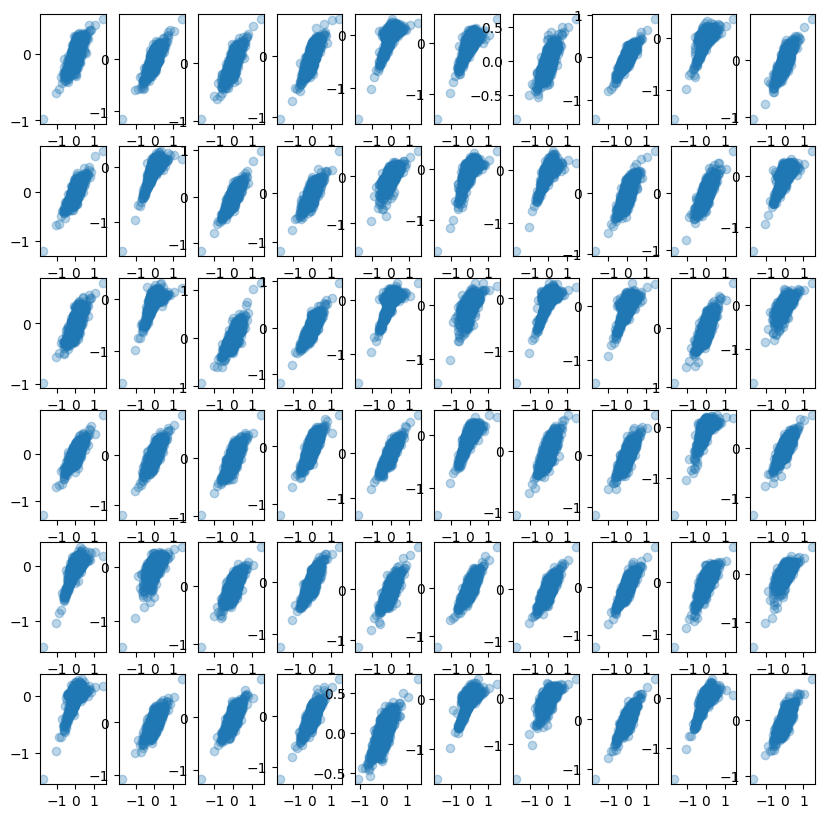

In [90]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=6, ncols=10, figsize=(10, 10))
for observation_index in range(0, observation_length):
    row = observation_index // 10
    column = observation_index % 10
    axs[row, column].scatter(x=src_values[:, observation_index, 0], y=predicted_values[:, observation_index], alpha=0.3)
fig.show()

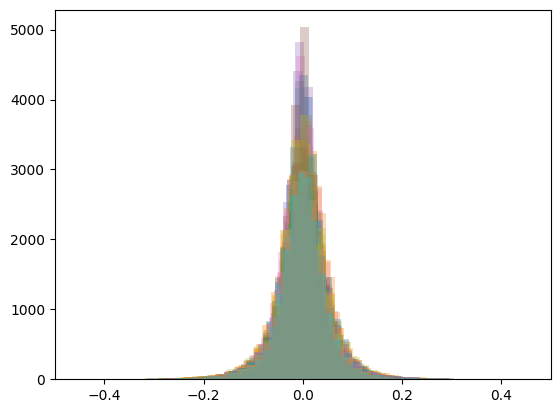

In [92]:
for observation_index in range(0, observation_length):
    plt.hist(predicted_values[:, observation_index] - src_values[:, observation_index, 0], alpha=0.3, bins=100)
plt.xlim(-0.5, 0.5)
plt.show()

In [95]:
pd.Series(src_values[:, 0, 0]).describe()

count    20040.000000
mean         0.001505
std          0.080778
min         -1.729000
25%         -0.030000
50%          0.002000
75%          0.034000
max          1.474000
dtype: float64

In [101]:
total_stats = None

for index in range(0, memory_values.shape[1]):
    stats = pd.Series(memory_values[:, index]).describe()
    stats.name = index
    if total_stats is None:
        total_stats = stats
    else:
        total_stats = pd.concat([total_stats, stats], axis=1)

In [102]:
total_stats

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,...,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000,20040.000000
mean,0.005203,0.010382,-0.024180,-0.050130,0.003588,-0.017958,0.017709,0.007370,-0.051583,-0.022627,...,0.020581,0.004815,0.029761,0.012570,0.000258,-0.011488,-0.007063,-0.043851,-0.002466,-0.001163
std,0.146542,0.104881,0.102056,0.099184,0.098350,0.118785,0.113273,0.093674,0.090197,0.118910,...,0.105825,0.112336,0.092987,0.120917,0.139932,0.116591,0.091931,0.082767,0.063895,0.129054
min,-1.380149,-0.856516,-1.348817,-0.910740,-1.009319,-1.220056,-0.854667,-1.121812,-0.916024,-1.046018,...,-1.037432,-1.194028,-0.698034,-1.361310,-1.676544,-1.181880,-0.946566,-0.987448,-0.624981,-1.605844
25%,-0.059045,-0.031200,-0.077377,-0.096783,-0.033380,-0.072769,-0.040564,-0.043309,-0.089059,-0.078327,...,-0.026476,-0.044384,-0.015727,-0.040171,-0.043019,-0.052057,-0.047406,-0.079360,-0.030471,-0.054923
50%,0.012627,0.018476,-0.033972,-0.052403,0.014399,-0.015294,0.007272,-0.002284,-0.041268,-0.020710,...,0.029087,0.010879,0.024155,0.021050,0.033491,0.002568,0.000284,-0.035454,0.003655,0.002972
75%,0.073167,0.060488,0.018518,-0.007779,0.052455,0.039897,0.063509,0.046753,-0.002107,0.035311,...,0.076256,0.059693,0.070628,0.075226,0.087090,0.042597,0.041699,0.001877,0.031986,0.057826
max,1.378663,1.752489,0.983480,1.526475,0.749490,0.879149,1.184478,1.267104,0.657597,1.184178,...,1.032928,1.143912,0.909920,1.066042,0.288251,1.200295,0.718360,0.494268,0.476675,1.245574


In [103]:
total_stats.to_csv(f"{model_name}_{model_version}.csv")

### Data Argument by Simulation

In [104]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.generator import AgentSimulationTrainDataGenerator
from fprocess import fprocess

In [ ]:
generator = AgentSimulationTrainDataGenerator(100, )